In [6]:
!pip install seaborn transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2025-06-10 17:45:39.019478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749577539.238362      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749577539.300222      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load dataset
df = pd.read_csv("/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv")
print(df.head())

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     

In [9]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')


In [10]:
# Preprocess labels
sentences = df['Text'].values
labels_raw = df['Sentiment'].values

In [11]:
# Map labels to integers
label_dict = {label: i for i, label in enumerate(np.unique(labels_raw))}
print(f"Label mapping: {label_dict}")
labels = np.array([label_dict[label] for label in labels_raw])

Label mapping: {' Acceptance   ': 0, ' Acceptance      ': 1, ' Accomplishment ': 2, ' Admiration ': 3, ' Admiration   ': 4, ' Admiration    ': 5, ' Adoration    ': 6, ' Adrenaline     ': 7, ' Adventure ': 8, ' Affection    ': 9, ' Amazement ': 10, ' Ambivalence ': 11, ' Ambivalence     ': 12, ' Amusement    ': 13, ' Amusement     ': 14, ' Anger        ': 15, ' Anticipation ': 16, ' Anticipation  ': 17, ' Anxiety   ': 18, ' Anxiety         ': 19, ' Appreciation  ': 20, ' Apprehensive ': 21, ' Arousal       ': 22, ' ArtisticBurst ': 23, ' Awe ': 24, ' Awe    ': 25, ' Awe          ': 26, ' Awe           ': 27, ' Bad ': 28, ' Betrayal ': 29, ' Betrayal      ': 30, ' Bitter       ': 31, ' Bitterness ': 32, ' Bittersweet ': 33, ' Blessed       ': 34, ' Boredom ': 35, ' Boredom         ': 36, ' Breakthrough ': 37, ' Calmness     ': 38, ' Calmness      ': 39, ' Captivation ': 40, ' Celebration ': 41, ' Celestial Wonder ': 42, ' Challenge ': 43, ' Charm ': 44, ' Colorful ': 45, ' Compassion': 4

In [12]:
len(sentences)

732

In [13]:
# Custom parameters
learning_rate = 3e-5
batch_size = 16
epochs = 10
max_len = 128 # 32, 64, 128, 256
weight_decay = 0.001


In [14]:

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:

# Tokenize and pad sequences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=max_len, truncation=True) for sent in sentences]
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, padding="post", truncating="post")

attention_masks = [[float(token_id > 0) for token_id in seq] for seq in input_ids]

In [17]:
# Convert to tensors
inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)


In [18]:
# Train-validation split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
inputs, labels, test_size=0.1, random_state=42
)
train_masks, val_masks = train_test_split(masks, test_size=0.1, random_state=42)

In [19]:
# DataLoader setup
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [20]:
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [21]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
"bert-base-uncased",
num_labels=len(label_dict),
output_attentions=False,
output_hidden_states=False,
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)

total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1 * total_steps) # 10% warmup

scheduler = get_linear_schedule_with_warmup(
optimizer,
num_warmup_steps=num_warmup_steps,
num_training_steps=total_steps
)

In [25]:

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")


Epoch 1/10


Training: 100%|██████████| 42/42 [00:14<00:00,  2.95it/s]


Average training loss: 5.6289

Epoch 2/10


Training: 100%|██████████| 42/42 [00:13<00:00,  3.11it/s]


Average training loss: 5.3215

Epoch 3/10


Training: 100%|██████████| 42/42 [00:13<00:00,  3.05it/s]


Average training loss: 4.9940

Epoch 4/10


Training: 100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Average training loss: 4.7102

Epoch 5/10


Training: 100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Average training loss: 4.4144

Epoch 6/10


Training: 100%|██████████| 42/42 [00:14<00:00,  2.85it/s]


Average training loss: 4.2407

Epoch 7/10


Training: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]


Average training loss: 4.0537

Epoch 8/10


Training: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]


Average training loss: 3.9394

Epoch 9/10


Training: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]


Average training loss: 3.8315

Epoch 10/10


Training: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]

Average training loss: 3.7834


In [26]:
# Validation
model.eval()
val_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

for batch in tqdm(val_dataloader, desc="Validation"):
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    val_loss += loss.item()

    preds = torch.argmax(logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())

    correct += (preds == b_labels).sum().item()
    total += b_labels.size(0)

avg_val_loss = val_loss / len(val_dataloader)
val_accuracy = correct / total

print(f"Validation loss: {avg_val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")

print("Training complete!")


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

Validation loss: 4.8489
Validation accuracy: 0.0946
Training complete!


In [27]:

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)



In [28]:
# Prepare label names based on label_dict (sorted by label index)
# Get only the labels actually used in predictions
used_label_indices = sorted(set(y_true) | set(y_pred))
label_names = [label for label, idx in sorted(label_dict.items(), key=lambda x: x[1]) if idx in used_label_indices]

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nBERT Validation Accuracy: {accuracy:.4f}")



BERT Validation Accuracy: 0.0946


In [29]:

# Classification report
print(classification_report(
    y_true, y_pred, 
    target_names=label_names, 
    labels=used_label_indices,
    digits=2
))



                        precision    recall  f1-score   support

         Acceptance          0.00      0.00      0.00         1
           Admiration        0.00      0.00      0.00         1
        Anticipation         0.00      0.00      0.00         1
        Arousal              0.00      0.00      0.00         1
                  Awe        0.00      0.00      0.00         1
         Awe                 0.00      0.00      0.00         1
             Betrayal        0.00      0.00      0.00         1
          Bittersweet        0.00      0.00      0.00         1
              Boredom        0.00      0.00      0.00         1
     Celestial Wonder        0.00      0.00      0.00         1
      Confusion              0.00      0.00      0.00         2
           Connection        0.00      0.00      0.00         1
        Contemplation        0.00      0.00      0.00         1
          Contentment        0.00      0.00      0.00         2
         Coziness            0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

<Figure size 1000x1000 with 0 Axes>

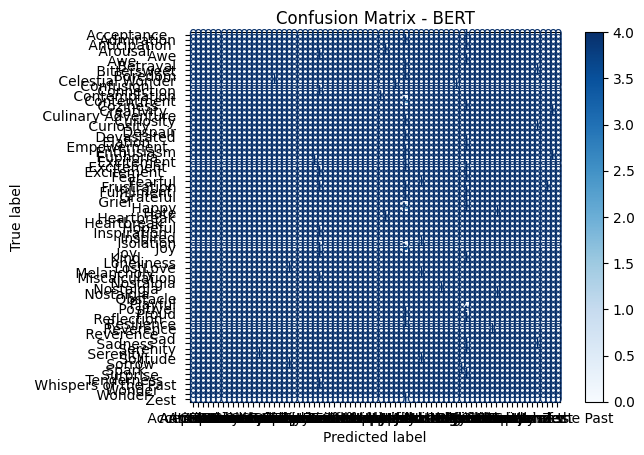

In [30]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=used_label_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
plt.figure(figsize=(10, 10))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - BERT")
plt.grid(False)
plt.show()